# Nonlinear regression: `predict` 

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

In [23]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npla

import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
%matplotlib inline

from plot_classifier import plot_classifier

In [24]:
plt.rcParams['font.size'] = 16

In [25]:
%autosave 0

Autosave disabled


## RBF features


In [26]:
def euclidean_dist_squared(X, Xtest): 
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)
def RBF_features(Xtrain, Xtest, σ=1):
    return np.exp(-0.5*euclidean_dist_squared(Xtest,Xtrain)/σ**2)


Make a synthetic 1D data set.

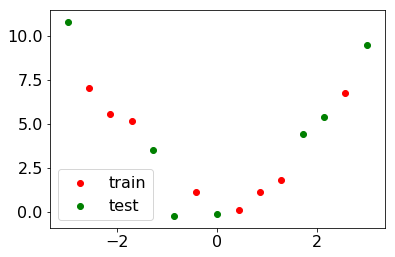

In [27]:
npr.seed(0)

n = 15
x = np.linspace(-3,3,n)
y = x**2 + npr.randn(n)

ntest = 7
ntrain = n-ntest

xtrain,xvalid,ytrain,yvalid = train_test_split(x,y,test_size=ntest)

plt.scatter(xtrain,ytrain,c='red', label='train');
plt.scatter(xvalid,yvalid,c='green',label='test');
plt.legend();

In [28]:
Xtrain = xtrain[:,None]
Xvalid = xvalid[:,None]

grid = np.linspace(np.min(x)-1,np.max(x)+1,1000)[:,None]

Recall this demo from a few weeks ago, about polynomial features:

p  |  train err   | valid err |
---+--------------+-----------+
0         55.6          118.3
1         48.8          133.7
2          2.6            8.2
3          1.1           17.3
4          0.6           24.2
5          0.5           27.3
6          0.1          135.2
7          0.0         1379.6


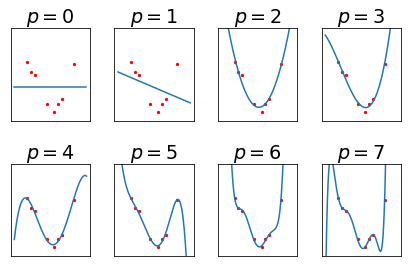

In [29]:
plt.figure()
plt.clf()

print("p  |  train err   | valid err |")
print("---+--------------+-----------+")
for p in range(8):
    pf = PolynomialFeatures(p)
    Z = pf.fit_transform(Xtrain)
    w = np.linalg.solve(Z.T @ Z, Z.T @ ytrain) # solve normal equations
    grid_poly = pf.fit_transform(grid)
    
    plt.subplot(2,4,p+1)
    plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
#     plt.scatter(xvalid,yvalid,c='green',label='test',s=5);
    plt.plot(grid, grid_poly@w)
    train_pred = Z@w
    train_err = np.sum((ytrain-train_pred)**2)
    valid_pred = pf.transform(Xvalid)@w
    valid_err = np.sum((yvalid-valid_pred)**2)
    plt.title('$p=%d$'%p)
    plt.xticks(())
    plt.yticks(())
    plt.ylim((np.min(y)-1,np.max(y)+1))
    print('%d %12.1f   %12.1f' % (p, train_err, valid_err))
plt.tight_layout();
#     print(max(abs(w)))
#     print(w)

We can do the same with RBF features:

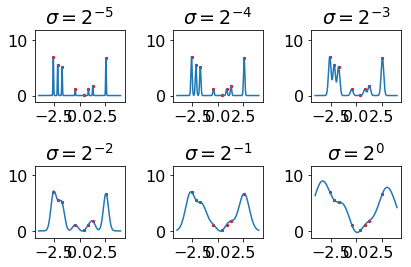

In [30]:
count = 1
for log_σ_val in np.arange(-5,1,1):
    σ_val = 2.0**log_σ_val
    Z = RBF_features(Xtrain,Xtrain,σ=σ_val)
    w = np.linalg.solve(Z.T @ Z + 0.000001*np.eye(ntrain), Z.T @ ytrain) # solve normal equations    
    plt.subplot(2,3,count)
    plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
    grid_rbf = RBF_features(Xtrain,grid,σ=σ_val)
    plt.plot(grid, grid_rbf@w);
    plt.title('$σ=2^{%d}$'%log_σ_val)
#     plt.xticks(())
#     plt.yticks(())
    plt.ylim((np.min(y)-1,np.max(y)+1))
    count += 1
plt.tight_layout();

## Multiple choice question

There many be more than one (or none) that are true.

With the standard RBF basis...

1. You create one feature per training example.
2. If we have $t$ test examples, the test feature matrix $\tilde{Z}$ is $t \times t$.
3. The training matrix $Z$ is a symmetric matrix. 
4. Larger $\sigma$ means lower training error.

### RBF + regularization

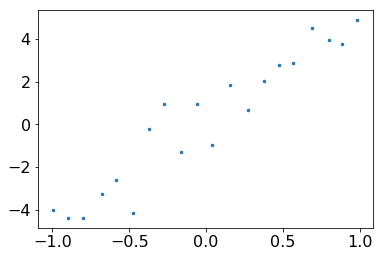

In [31]:
N = 20
X = np.linspace(-1,1,N)+npr.randn(N)*0.01
X=X[:,None]
y = npr.randn(N,1) + X*5

grid = np.linspace(min(X),max(X),1000)[:,None]


plt.plot(X,y,'.',markersize=5);

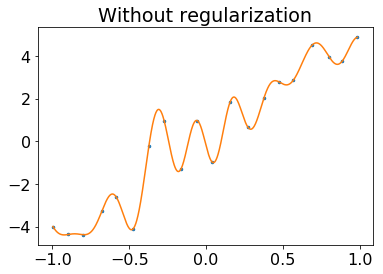

In [32]:
Z = RBF_features(X,X,σ=0.1)

v = npla.solve(Z.T @ Z, Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF@v);
plt.title("Without regularization");

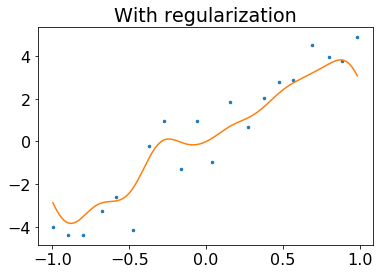

In [33]:
Z = RBF_features(X,X,σ=0.1)

λ=1
v = npla.solve(Z.T @ Z + λ*np.eye(Z.shape[1]), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF@v);
plt.title("With regularization");

### Back to linear classifiers: non-separable data and change of basis

- Can we use linear classifiers for nonlinear boundaries?
- Answer: yes, like we used linear regression with change-of-basis.

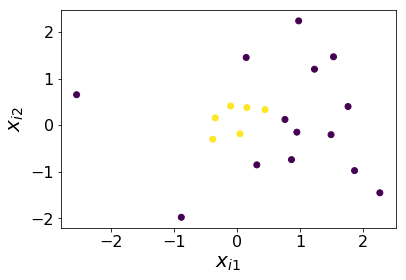

In [34]:
n = 20
d = 2
np.random.seed(0)
X = np.random.randn(n,d)
y = np.sum(X**2,axis=1) < 0.4

plt.scatter(X[:,0], X[:,1], c=y);
plt.xlabel("$x_{i1}$", fontsize=20);
plt.ylabel("$x_{i2}$", fontsize=20);

- The above is not linearly separable.

Training accuracy 0.7


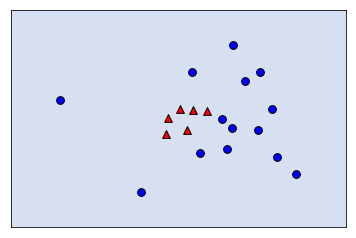

In [35]:
svm = SVC(kernel="linear")
svm.fit(X,y)

plot_classifier(X,y,svm)

print("Training accuracy", svm.score(X,y))

Above: we can't perfectly classify all the points with a linear boundary.

But what if we transform the features as follows:

$$z_{i1} = x_{i1}^2$$
$$z_{i2} = x_{i2}^2$$

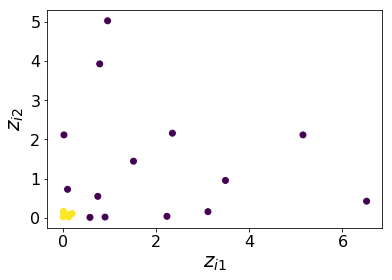

In [36]:
Z = X**2

plt.scatter(Z[:,0], Z[:,1], c=y);
plt.xlabel("$z_{i1}$", fontsize=20);
plt.ylabel("$z_{i2}$", fontsize=20);

Training accuracy 1.0


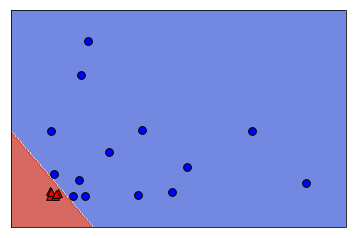

In [37]:
svm = SVC(kernel="linear", C=100)
svm.fit(Z,y)

plot_classifier(Z,y,svm)

print("Training accuracy", svm.score(Z,y))

What does this linear boundary in $Z$-space correspond to _in the original ($X$) space_?

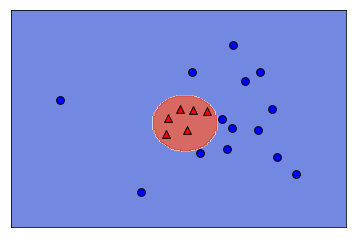

In [38]:
plot_classifier(X, y, svm, transformation=lambda X: X**2);

It's an ellipse!

In [39]:
svm.coef_

array([[-6.3044071 , -4.24523907]])

### RBF SVM hyperparameters $\sigma$ and $\lambda$

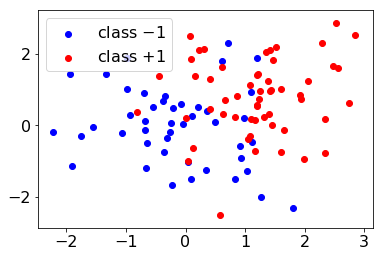

In [40]:
# generate synthetic 2D data set
n = 100
X = npr.randn(n,2)
y = npr.choice((-1,+1),size=n)
X[y>0] += 1

plt.scatter(X[y<0,0], X[y<0,1], color="b", label="class $-1$")
plt.scatter(X[y>0,0], X[y>0,1], color="r", label="class $+1$")
plt.legend(loc="best")
plt.show()

Below:

- Larger `gamma` leads to more complex boundaries; in our notation, this hyperparameter is $\frac{1}{\sigma}$. 
- Larger `C` means less regularization; in our notation, this hyperparameter is $\frac{1}{\lambda}$.

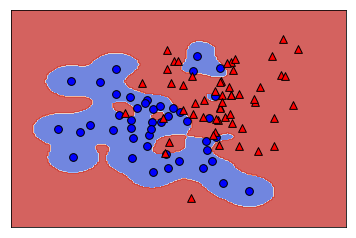

In [41]:
svm = SVC(kernel="rbf", gamma=10, C=10)
svm.fit(X,y)
plot_classifier(X, y, svm)

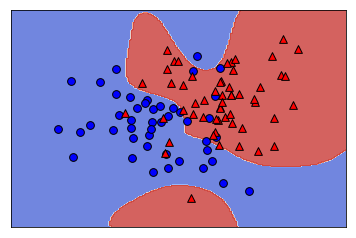

In [42]:
svm = SVC(kernel="rbf", gamma=1, C=10) # larger length scale (sigma)
svm.fit(X,y)
plot_classifier(X, y, svm)

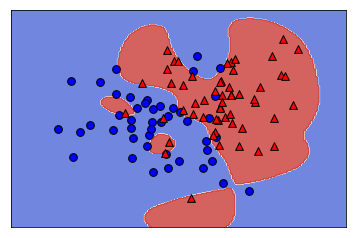

In [43]:
svm = SVC(kernel="rbf", gamma=1, C=1000) # less regularization
svm.fit(X,y)
plot_classifier(X, y, svm)

You can think of `gamma` (or $\sigma$) as controlling the abruptness at which we can change the class, whereas `C` (or $\lambda$) controls how much we worry about making errors.

### The interaction between hyperparameters

- What makes hyperparameter optimization difficult?
- Can't we just tune them one at a time?

In [59]:
sigma_min = -3
sigma_max = 3
lambda_min = -3
lambda_max = 1
sigma_grid = 10.0**np.arange(sigma_min,sigma_max+1)
lambda_grid = 10.0**np.arange(lambda_min,lambda_max+1)
train_errors = np.zeros((len(sigma_grid),len(lambda_grid)))
valid_errors = np.zeros((len(sigma_grid),len(lambda_grid)))

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

for i,σ in enumerate(sigma_grid):
    for j,λ in enumerate(lambda_grid):
        svm = SVC(kernel="rbf", gamma=1/σ, C=1/λ)
        svm.fit(X_train, y_train)
        train_errors[i,j] = 1-svm.score(X_train,y_train)
        valid_errors[i,j] = 1-svm.score(X_valid,y_valid)

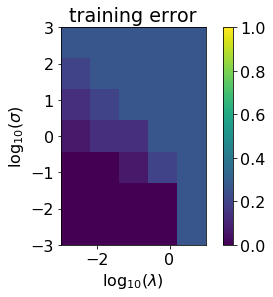

In [60]:
plt.imshow(train_errors,origin="lower",vmin=0,vmax=1,extent=(lambda_min,lambda_max,sigma_min,sigma_max))
plt.ylabel('$\log_{10}(\sigma)$')
plt.xlabel('$\log_{10}(\lambda)$')
plt.title('training error')
plt.colorbar();

Above: as expected, we get the best training error with the least regularization and the smallest $\sigma$.

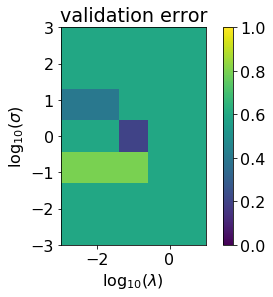

In [61]:
plt.imshow(valid_errors,origin="lower",vmin=0,vmax=1,extent=(lambda_min,lambda_max,sigma_min,sigma_max))
plt.ylabel('$\log_{10}(\sigma)$')
plt.xlabel('$\log_{10}(\lambda)$')
plt.title('validation error')
plt.colorbar();

- However, the situation changes for validation error. 
- Furthermore, the hyerparameters interact with each other
  - If we set $\sigma=1$ and optimized $\lambda$, we'd get something non-optimal.

### What is regularization actually doing? (Bonus, to read over later)

- It seems like `gamma` (or $\sigma$) matters more than `C` (or $\lambda$)
- The effect of `C` (or $\lambda$) is somewhat subtle

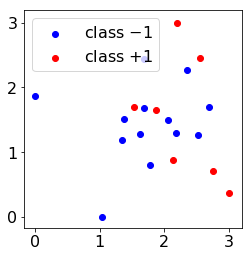

In [62]:
# generate synthetic 2D data set
npr.seed(0)
n = 20
X = npr.randn(n,2)
X -= np.min(X,axis=0)[None]
X /= np.max(X,axis=0)[None]
X *= 3
y = npr.choice((-1,+1),size=n)

plt.scatter(X[y<0,0], X[y<0,1], color="b", label="class $-1$")
plt.scatter(X[y>0,0], X[y>0,1], color="r", label="class $+1$")
plt.legend(loc="best")
plt.axis('equal');
plt.axis('square');

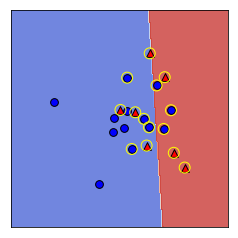

In [63]:
svm = SVC(kernel="linear", C=10)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

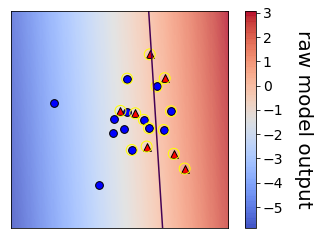

In [64]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw")
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

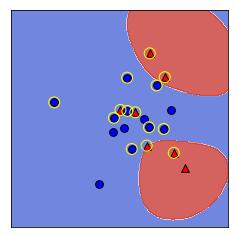

In [65]:
svm = SVC(kernel="rbf", gamma=1, C=10)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

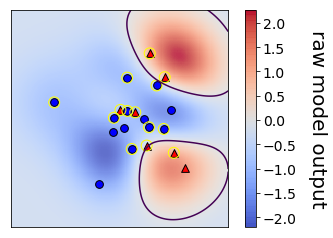

In [66]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw")
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

We'd expect more regularization to correspond to simpler models, meaning that if we increase the regularization strength we might be able to get rid of one of the "islands" of red. 

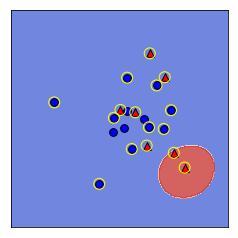

In [67]:
svm = SVC(kernel="rbf", gamma=1, C=0.7)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120); 
plt.axis('equal');
plt.axis('square');

Above: by increasing the regularization, we got two of the red "islands" to disappear from the classification surface. But since those red points are still support vectors (yellow circles), they are still affecting the raw model output, as shown below.

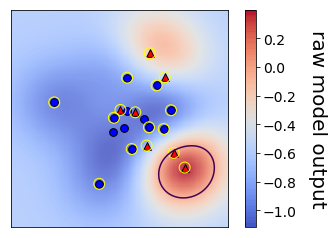

In [68]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw") 
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

Note: if you look carefully at the colours and colourbar, you'll see that something is a support vector if it's blue and the raw model output is above $-1$ or if it's red and the raw model output is below $1$.

### Adapting Counting & Distance-based methods for regression (bonus)

We can adapt our classification methods to perform regression.

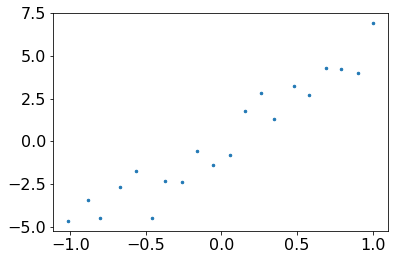

In [69]:
N = 20
X = np.linspace(-1,1,N)+npr.randn(N)*0.01
X=X[:,None]
y = npr.randn(N,1) + X*5
y = y.ravel()

grid = np.linspace(min(X),max(X),1000)[:,None]


plt.plot(X,y,'.',markersize=5);

#### Decision tree regression

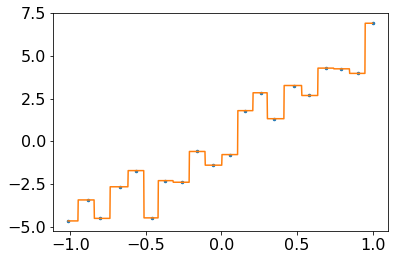

In [70]:
dtr = DecisionTreeRegressor()
dtr.fit(X,y)
plt.plot(X,y,'.',markersize=5);
plt.plot(grid, dtr.predict(grid));

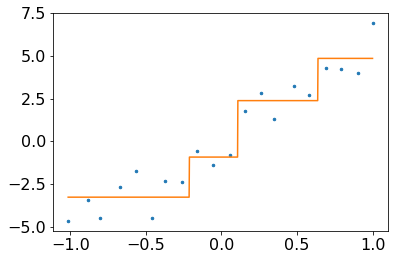

In [71]:
dtr = DecisionTreeRegressor(max_depth=2)
dtr.fit(X,y)
plt.plot(X,y,'.',markersize=5);
plt.plot(grid, dtr.predict(grid));

#### Random forest regression

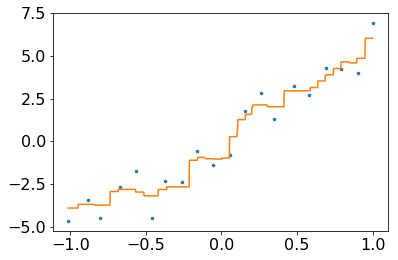

In [72]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(X,y)
plt.plot(X,y,'.',markersize=5);
plt.plot(grid, rfr.predict(grid));

#### KNN regression

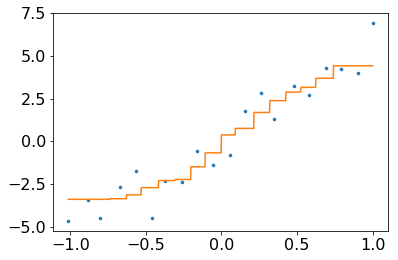

In [73]:
knnr = KNeighborsRegressor(n_neighbors=5, weights="uniform")
knnr.fit(X,y)
plt.plot(X,y,'.',markersize=5);
plt.plot(grid, knnr.predict(grid));

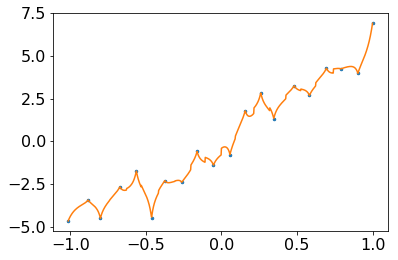

In [74]:
knnr = KNeighborsRegressor(n_neighbors=5, weights="distance")
knnr.fit(X,y)
plt.plot(X,y,'.',markersize=5);
plt.plot(grid, knnr.predict(grid));

Other possible approaches:

- Regression tree with linear regression at leaves.
- Probabilistic models, i.e. fit $p(x_i\mid y)$ and $p(y)$ with a Gaussian or other model.
- "Locally linear regression": for each $x_i$, fit a linear model weighted by distance. 
- Ensembles of these.

# Summary

- RBF features are a flexible nonparametric basis.
  - Expensive at test time, needs to loop through all training examples. 
- Change of basis can be used for linear classifiers as well (not just regression).
  - Can turn a non-separable dataset into a separable one.
  - The ideas from regression carry over.
- Hyperparameter search
  - It's a pain, hard to avoid.
  - Becoming more automated over time.
- Tree/KNN regression
  - Popular and effective regression models.
  